# Delayed Flights Random Forest

In [54]:
# Initial imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report,  accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
# load data flight from amazon aws 
data = "https://airport-efficiency.s3.amazonaws.com/Merged_cleaned_airport_data.csv"
df = pd.read_csv(data)
df.head()

,YEAR,MONTH,DAY_OF_WEEK,BRANDED_CODE_SHARE,ORIGIN,DEST,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAYED,DATE,COVID,DELAY_REASON
0,2018,1,1,UA,BWI,DEN,Colorado,1608,1600.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
1,2018,1,1,UA,BWI,ORD,Illinois,1644,1637.0,-7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
2,2018,1,1,UA,BWI,IAH,Texas,1806,1800.0,-6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
3,2018,1,1,UA,BWI,IAH,Texas,828,828.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0
4,2018,1,1,UA,BWI,DEN,Colorado,810,802.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0


In [3]:
# merge "codeshares" to their corresponding airlines 
df.loc[(df.BRANDED_CODE_SHARE == "UA_CODESHARE"), "BRANDED_CODE_SHARE"] = "UA"
df.loc[(df.BRANDED_CODE_SHARE == "AA_CODESHARE"), "BRANDED_CODE_SHARE"] = "AA"
df.loc[(df.BRANDED_CODE_SHARE == "DL_CODESHARE"), "BRANDED_CODE_SHARE"] = "DL"
df.loc[(df.BRANDED_CODE_SHARE == "AS_CODESHARE"), "BRANDED_CODE_SHARE"] = "AS"


In [4]:
#divide the states into five regions 
northeast = ['Massachusetts',
'Rhode Island',
'Connecticut',
'Vermont',
'New Hampshire',
'Maine',
'Pennsylvania',
'New Jersey',
'New York'
]

souteast = ['Georgia',
'North Carolina',
'South Carolina',
'Virginia',
'West Virginia',
'Kentucky',
'Tennessee',
'Mississippi',
'Alabama',
'Delaware',
'Maryland',
'Florida',
'Louisiana',
'Arkansas'
]

midwest = ['Minnesota',
'Wisconsin',
'Illinois',
'Ohio',
'Indiana',
'Michigan',
'Missouri',
'Iowa',
'Kansas',
'Nebraska',
'North Dakota',
'South Dakota'
]

southwest = ['New Mexico',
'Arizona',
'Oklahoma',
'Texas'
]

west = ['California',
'Colorado',
'Nevada',
'Hawaii',
'Alaska',
'Oregon',
'Utah',
'Idaho',
'Montana',
'Wyoming',
'Washington'
]

noncontinental = ['U.S. Virgin Islands',
'Puerto Rico'
]

In [5]:
# this code created a new column "region" and classifies each state to its corresponding region 
regions=pd.DataFrame([northeast,souteast,midwest,southwest,west,noncontinental],index=['northeast','souteast','midwest','southwest','west','noncontinental'])
regions=regions.reset_index().melt('index')
df['Region'] = df['DEST_STATE_NM'].map(dict(zip(regions['value'],regions['index'])))

In [6]:
# drop more columns to make sure it does not overlap with delays. 
drop = ['DEP_TIME','DEP_DELAY_GROUP',  'DEST_STATE_NM', 'DEST', 'DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'DELAY_REASON', 'CRS_DEP_TIME']
df_dropped = df.drop( drop , 1)

c:\Users\nizar\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# check the columns that are going to be used in our machine learning model 
df_dropped.columns.values.tolist()

['YEAR',
 'MONTH',
 'DAY_OF_WEEK',
 'BRANDED_CODE_SHARE',
 'ORIGIN',
 'DEP_TIME_BLK',
 'CANCELLED',
 'DIVERTED',
 'DELAYED',
 'DATE',
 'COVID',
 'Region']

# Encode Columns 
using get_dummies

In [10]:
brand_df = pd.get_dummies(df_dropped, columns=["BRANDED_CODE_SHARE"])
origin_df = pd.get_dummies(brand_df, columns=["ORIGIN"])
region_df = pd.get_dummies(origin_df, columns=["Region"])
final_df = pd.get_dummies(region_df, columns=["DEP_TIME_BLK"])
final_df['DATE'] = pd.to_datetime(final_df['DATE'], format='%Y-%m-%d')
final_df['DAY_OF_MONTH'] = final_df.DATE.dt.day
final_df = final_df.drop('DATE', 1)

c:\Users\nizar\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


## Loading and Preprocessing Loans Encoded Data

In [11]:
# Define features set
X = final_df.drop(columns=["DELAYED"])
X.head()

,YEAR,MONTH,DAY_OF_WEEK,CANCELLED,DIVERTED,COVID,BRANDED_CODE_SHARE_AA,BRANDED_CODE_SHARE_AS,BRANDED_CODE_SHARE_B6,BRANDED_CODE_SHARE_DL,...,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,DAY_OF_MONTH
0,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,22
1,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,22
2,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,22
3,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


 # Separate the features (X) from the target (y) 

In [12]:
# Define target vector
y = final_df["DELAYED"]
y[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: DELAYED, dtype: float64

 # Split our data into training and testing

In [13]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(812203, 45)
(270735, 45)
(812203,)
(270735,)


# Feature Scaling

In [15]:
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Random Forest Model

In [61]:
# Creating the Random Forest classifier instance
model = RandomForestClassifier(n_estimators= 10, random_state = 0)

In [62]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

## Making Predictions Using the Tree Model

In [79]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

## Model Evaluation

In [80]:
y_test.value_counts()

0.0    222493
1.0     48242
Name: DELAYED, dtype: int64

In [81]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=[1, 0])
cm_df = pd.DataFrame(
    cm, index=['Actual Delayed (1)', 'Actual On-Time (0)'], 
    columns=['Predicted Delayed (1)', 'Predicted On-Time (0)']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [82]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted Delayed (1),Predicted On-Time (0)
Actual Delayed (1),12417,35825
Actual On-Time (0),15064,207429


Accuracy Score : 0.8120339076957173
Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89    222493
         1.0       0.45      0.26      0.33     48242

    accuracy                           0.81    270735
   macro avg       0.65      0.59      0.61    270735
weighted avg       0.78      0.81      0.79    270735



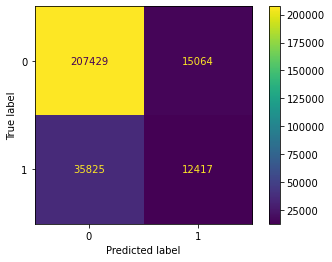

In [83]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions, labels=[0, 1]))
cm.plot()
plt.show()

Feature: 0, Score: 0.05362
Feature: 1, Score: 0.19239
Feature: 2, Score: 0.15070
Feature: 3, Score: 0.00167
Feature: 4, Score: 0.00248
Feature: 5, Score: 0.00647
Feature: 6, Score: 0.00547
Feature: 7, Score: 0.00111
Feature: 8, Score: 0.00280
Feature: 9, Score: 0.00427
Feature: 10, Score: 0.00123
Feature: 11, Score: 0.00055
Feature: 12, Score: 0.00173
Feature: 13, Score: 0.00450
Feature: 14, Score: 0.00010
Feature: 15, Score: 0.01008
Feature: 16, Score: 0.00661
Feature: 17, Score: 0.00479
Feature: 18, Score: 0.00334
Feature: 19, Score: 0.00919
Feature: 20, Score: 0.00121
Feature: 21, Score: 0.00920
Feature: 22, Score: 0.01028
Feature: 23, Score: 0.00709
Feature: 24, Score: 0.00594
Feature: 25, Score: 0.00121
Feature: 26, Score: 0.00970
Feature: 27, Score: 0.00541
Feature: 28, Score: 0.00743
Feature: 29, Score: 0.00379
Feature: 30, Score: 0.00498
Feature: 31, Score: 0.00487
Feature: 32, Score: 0.00517
Feature: 33, Score: 0.00443
Feature: 34, Score: 0.00428
Feature: 35, Score: 0.00488
Fe

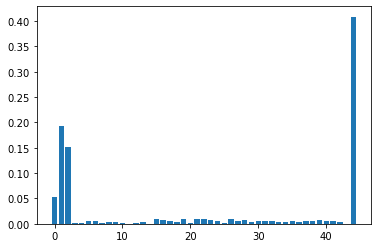

In [68]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [69]:
# We can sort the features by their importance.
columns = list(X)
importance_df = pd.DataFrame({'Feature': columns, 'Importance' : importance})
importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
44,DAY_OF_MONTH,0.408797
1,MONTH,0.192389
2,DAY_OF_WEEK,0.150702
0,YEAR,0.053624
22,Region_souteast,0.010278
15,BRANDED_CODE_SHARE_WN,0.010082
26,DEP_TIME_BLK_0600-0659,0.009703
21,Region_northeast,0.009204
19,Region_midwest,0.009192
28,DEP_TIME_BLK_0800-0859,0.007427


# Increase n_estimator

In [92]:
model2 = RandomForestClassifier(n_estimators= 64, random_state = 0)
model2 = model2.fit(X_train_scaled, y_train)
predictions2 = model2.predict(X_test_scaled)

In [93]:
cm2 = confusion_matrix(y_test, predictions2, labels=[1, 0])
cm_df2 = pd.DataFrame(
    cm2, index=['Actual Delayed (1)', 'Actual On-Time (0)'], 
    columns=['Predicted Delayed (1)', 'Predicted On-Time (0)']
)

# Calculating the accuracy score
acc_score2 = accuracy_score(y_test, predictions2)

In [94]:
# Displaying results
print("Confusion Matrix")
display(cm_df2)
print(f"Accuracy Score : {acc_score2}")
print("Classification Report")
print(classification_report(y_test, predictions2))


Confusion Matrix


,Predicted Delayed (1),Predicted On-Time (0)
Actual Delayed (1),12419,35823
Actual On-Time (0),14204,208289


Accuracy Score : 0.815217832936266
Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89    222493
         1.0       0.47      0.26      0.33     48242

    accuracy                           0.82    270735
   macro avg       0.66      0.60      0.61    270735
weighted avg       0.78      0.82      0.79    270735



In [95]:
model3 = RandomForestClassifier(n_estimators= 128, random_state = 0)
model3 = model3.fit(X_train_scaled, y_train)
predictions3 = model3.predict(X_test_scaled)

In [98]:
cm3 = confusion_matrix(y_test, predictions3, labels=[1, 0])
cm_df3 = pd.DataFrame(
    cm3, index=['Actual Delayed (1)', 'Actual On-Time (0)'], 
    columns=['Predicted Delayed (1)', 'Predicted On-Time (0)']
)

# Calculating the accuracy score
acc_score3 = accuracy_score(y_test, predictions3)

In [99]:
# Displaying results
print("Confusion Matrix")
display(cm_df3)
print(f"Accuracy Score : {acc_score3}")
print("Classification Report")
print(classification_report(y_test, predictions3))

Confusion Matrix


,Predicted Delayed (1),Predicted On-Time (0)
Actual Delayed (1),12389,35853
Actual On-Time (0),13854,208639


Accuracy Score : 0.8163998005429663
Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89    222493
         1.0       0.47      0.26      0.33     48242

    accuracy                           0.82    270735
   macro avg       0.66      0.60      0.61    270735
weighted avg       0.79      0.82      0.79    270735



# Different criterion

In [101]:
model4 = RandomForestClassifier(n_estimators= 128, criterion='entropy', random_state = 0)
model4 = model4.fit(X_train_scaled, y_train)
predictions4 = model4.predict(X_test_scaled)

In [102]:
cm4 = confusion_matrix(y_test, predictions3, labels=[1, 0])
cm_df4 = pd.DataFrame(
    cm4, index=['Actual Delayed (1)', 'Actual On-Time (0)'], 
    columns=['Predicted Delayed (1)', 'Predicted On-Time (0)']
)

# Calculating the accuracy score
acc_score4 = accuracy_score(y_test, predictions4)

In [103]:
# Displaying results
print("Confusion Matrix")
display(cm_df4)
print(f"Accuracy Score : {acc_score4}")
print("Classification Report")
print(classification_report(y_test, predictions4))

Confusion Matrix


,Predicted Delayed (1),Predicted On-Time (0)
Actual Delayed (1),12389,35853
Actual On-Time (0),13854,208639


Accuracy Score : 0.816240973645816
Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89    222493
         1.0       0.47      0.26      0.33     48242

    accuracy                           0.82    270735
   macro avg       0.66      0.60      0.61    270735
weighted avg       0.79      0.82      0.79    270735

